In [1]:
# owslib is needed for the WFS query
!../py/modules/pkginstall.sh "owslib"

Installed owslib 0.33.0.


# Accessing Data

```{admonition} Summary
:class: hint

This section explains four ways to access data: 

- Local files
- API
- Web Coverage Service (WCS)
- Web Feature Service (WFS)

```

## Local files

Data is often stored in a file on your computer. However, depending on where you are running Python - whether on your own computer or in an online platform like JupyterLab - `local` storage could refer to your computer's hard drive, a remote server, or a cloud service.

The data will be accessible through absolute or relative path. 

### Absolute File Path

When specifying a local file path in Python, there are three common formats:

- Double backslashes (`\\`) → `"C:\\Users\\file.json"`
- Raw string (prefix with `r`) → `r"C:\Users\file.json"`
- Forward slashes (`/`) → `"C:/Users/file.json"`

`````{admonition} Note
:class: note
In Python, single backslashes (`\`) are treated as [escape characters](https://en.wikipedia.org/wiki/Escape_character), which is why using double backslashes (`\\`) or a raw string (`r""`) is necessary to avoid errors.
`````

### Relative File Path

`````{admonition} Use Python's pathlib
:class: danger
Use Python's [pathlib](https://docs.python.org/3/library/pathlib.html) to write code that works on any operating system, whether it's Windows, Mac, or Linux. This module simplifies file and folder management by providing a consistent, structured approach. By using pathlib, your code becomes more portable, allowing colleagues on different systems to run it without path modification and reproduce your results.
`````

Here is a example how the code with `pathlib` can look like:

In [2]:
from pathlib import Path

base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data" # refers to the folder path named "00_data"
INPUT.mkdir(exist_ok=True) # creates the "00_data" folder if it doesn't already exist.


Explainations:
- `Path.cwd()` → Gets the current working directory (cwd), which is the folder where your Jupyter Notebook or Python script is running.
- `.parents[0]` → moves one level up from the current working directory.

### Defining parameters at the beginning of a Jupyter Notebook

It is a good idea to define parameters at the beginning of a Jupyter Notebook (typically in the first few code cells), using CAPITAL LETTER to make them easily identifiable.

`````{admonition} constants
In Python, variables written in all CAPITAL LETTERS are commonly referred to as constants. Learn more here: [Python Constants: Improve Your Code's Maintainability](https://realpython.com/python-constants/).

**Why should I use constants?**

Using constants in a Python script or Jupyter Notebook helps to:

- Reuse frequently used variables that should not change.
- Make key parameters easy to find and modify.
- Follows a common Python naming convention.
`````

### Example of using constants and pathlip 

In [19]:
from pathlib import Path

# Defining constants at the top of the notebook

base_path = Path.cwd().parents[0]  # Moves one level up from the notebook / folder
OUTPUT = base_path / "out"         # Directory for saving figures, reports, etc.
WORK_DIR = base_path / "tmp"       # Working directory

In [20]:
current_path = Path.cwd()
mydata = current_path.parents[0] / "00_data" / "Biotopwerte_Dresden_2028.geojson"

Since we defined `INPUT` already above, this can be shortened.

In [21]:
mydata = INPUT / "Biotopwerte_Dresden_2028.geojson"

Compare an example for an absolute path in Windows:
```python
file_path = Path("C:/Users/files/00_data/LBM2018IS_DD.json")
```

`````{admonition} pathlib not always supported
:class: warning
Some older Python packages do not support paths from pathlib. For these cases, convert the pathlib object to a string first (e.g. `str(mydata)`).
`````

To know whether a variable is a string or a pathlib object, use the jupyter `?`.

In [ ]:
?mydata

## Application Programming Interface (API)


For retriving data from an API the package `request` is needed.

In [22]:
import requests

Then the path including the URL string is imported.

In [23]:
path="http://dataverse-test.ioer.de:8080/api/access/datafile/344"

Then using the GET method a request send to the path to access the data from the server. 

In [ ]:
response = requests.get(path)

Based on the format of the data in the API, the response should be converted. To findout the response format, check the `Content Type`.

In [ ]:
print(response.headers["Content-Type"])

In the following example, it converts the response of JSON format to a Python data structures and the data stored in a data variable `api_data`

In [ ]:
api_data = response.json()

## Web Feature Service (WFS)


Web Feature Service (WFS) data is often available from official government units. One example is the [Dresden Opendata Portal](https://opendata.dresden.de/). For instance, the WFS for Stadtteile (city districts) can be found [here](https://opendata.dresden.de/informationsportal/?open=1&result=493101D03C794E9C99CD8B2BAC194FEC#app/mainpage////).

Below, we show how to query this data in Python.

Load the dependencies first.

In [27]:
from io import BytesIO
from urllib.parse import urlencode
# packages:
import contextily as cx
import geopandas as gp
import pandas as pd
import requests
from owslib.wfs import WebFeatureService
import matplotlib.pyplot as plt

Before accessing the data, the layer name is required. To extract the layer name, the node-id should be defined which is mentioned in the [WFS URL](https://kommisdd.dresden.de/net3/public/ogcsl.ashx?nodeid=188&service=wfs&request=getcapabilities).

In [28]:
topics_dd = "https://kommisdd.dresden.de/net3/public/ogcsl.ashx"

params = {
    #"nodeid": 1108,
    "nodeid": 188,
    "service": "wcs",
}
wfs_url = f"{topics_dd}?{urlencode(params)}"

wfs = WebFeatureService(url=wfs_url, version='2.0.0')

Turn the response into a DataFrame (for better display, if many layers are returned), and display available layer-names. In our case, there is only one.

In [29]:
pd.DataFrame(wfs.contents.keys())

,0
0,cls:L137


To get the first layer name directly the [0] is used.

In [30]:
layer_name = list(wfs.contents.keys())[0]

Next, a function is written to request features for the layer, using the `requests` library. 

This will also turn features into a Geopandas GeoDataFrame, which is a suitable spatial data format in Python.

In [31]:
def wfs2gp(layer_name, url):
    """Request a WFS feature layer (layer_name) and turn into GeoDataFrame"""
    params = {
        'service': 'WFS',
        'version': '2.0.0',
        'request': 'GetFeature',
        'TYPENAMES': layer_name,
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
       raise Exception(f"Error fetching data: {response.status_code} {response.text}")
    return gp.read_file(BytesIO(response.content))

gdf = wfs2gp(layer_name, wfs_url)

Have a peek at the returned data.

In [32]:
gdf.head(2)

,gml_id,blocknr,bez,bez_lang,flaeche_km2,sst,sst_klar,historie,aend,geometry
0,L137.44,44,Dresdner Heide,Dresdner Heide,48.3382,None,None,akt,2024-08-01T00:00:00,"POLYGON ((421110.242 5664598.097, 421107.492 5..."
1,L137.42,42,Bühlau/Weißer Hirsch,Bühlau/Weißer Hirsch mit Rochwitz und Loschwit...,6.7596,None,None,akt,2024-08-01T00:00:00,"POLYGON ((418950.748 5655291.196, 418953.143 5..."


... and plot a map which is explained in [Creating Maps Chapter](https://stag.training.fdz.ioer.info/notebooks/305_mapping.html#creating-maps).

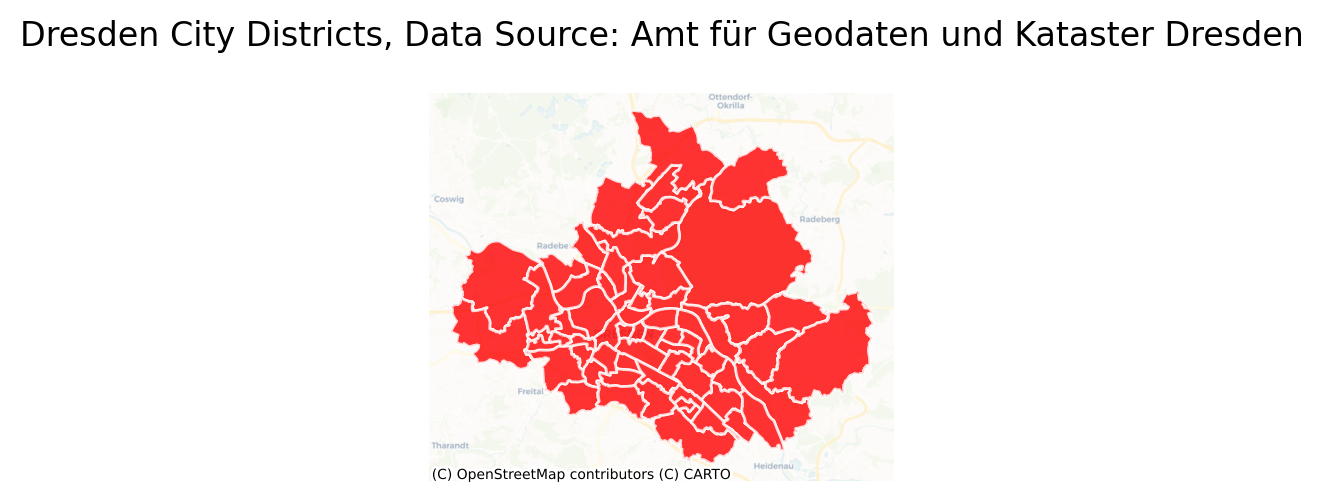

In [33]:
CRS_PROJ = "epsg:3857"

gdf.to_crs(CRS_PROJ, inplace=True)
fig, ax = plt.subplots(figsize=(3, 7), dpi=200)
ax = gdf.plot(
    ax=ax,
    alpha=0.8,
    linewidth=1,
    edgecolor="white",
    facecolor="red",
    markersize=300)
cx.add_basemap(
    ax, alpha=0.5,
    source=cx.providers.CartoDB.Voyager,
    attribution_size=5)
ax.set_title("Dresden City Districts, Data Source: Amt für Geodaten und Kataster Dresden")
# turn of axes display
ax.set_axis_off()

```{admonition} Query a different nodeid!
:class: dropdown, attention
You can replace "nodeid" with any other WFS Data Source from the Dresden Opendata Portal. Update the nodeid and re-run the code above to see the different data rendered.
```

## Web Coverage Service (WCS) 

````{admonition} Biodiversity area indicator
:class: tip, dropdown

In Germany, there is a wide variety of different habitats, also known as biotopes. These biotopes can be of natural origin, such as those found in marine and coastal areas, inland waters, terrestrial and semi-terrestrial zones, as well as mountainous regions like the Alps. However, there are also near-natural biotopes that arise due to technical or infrastructural conditions, such as small green spaces and open areas in urban environments.

Due to their specific characteristics, these biotopes can be categorized into different biotope types based on uniform and distinguishable criteria.

The biodiversity indicator assesses the quality and diversity of biotope types as habitats for various species. This evaluation is carried out using biotope value points ranging from 0-27, which are in accordance with the [German Federal Compensation Regulation](https://www.bmuv.de/themen/naturschutz/gebietsschutz-und-vernetzung/ueberblick-gebietsschutz-und-vernetzung). These points are combined with spatial land cover data and intermittently available specialized data on the state of ecosystems. This data combination enables a comparative assessment of Germany’s ecosystem inventory in terms of both area and quality.

By applying biotope value points, a monetary valuation can also be conducted. This valuation is based on the average costs associated with the creation, development, and maintenance of higher-value biotopes.

For more information, see description on the [IOER FDZ website](https://ioer-fdz.de/en/germanys-ecosystems/ecosystem-services/biodiversity-area-indicator)

```{admonition} Recommended citation
:class: attention

Syrbe, Ralf-Uwe, 2025, "Biotopwerte Dresden 2018", https://doi.org/10.82617/ioer-fdz/HPXYJD, ioerDATA, V1 
```

````

````{admonition} access a ZIP file from a remote server
:class: dropdown

To extract a ZIP file from a remote server: First, a local working directory is created. Then, using (_importing_) a method `tools.get_zip_extract()` that has been prepared for this book, the data is downloaded from a remote source.


from pathlib import Path

base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data"
INPUT.mkdir(exist_ok=True)

import sys

module_path = str(base_path / "py")
if module_path not in sys.path:
    sys.path.append(module_path)
from modules import tools

sample_data_url = 'https://datashare.tu-dresden.de/s/KEL6bZMn6GegEW4/download'

tools.get_zip_extract(
    uri_filename=sample_data_url,
    output_path=INPUT,
    write_intermediate=True)

 `````{admonition} Upload data
:class: danger

If you want to work with data stored on your local computer, but your jupyter service runs somewhere else, use drag & drop to add data to Jupyter. The left explorer view is comparable to Windows Explorer.
`````
````